In [1]:
import os
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# Path to ablation folder
notebook_dir = os.path.abspath("")
folder_path = os.path.join(notebook_dir, "..", "results", "experiments", "abliation")

# List to collect dataframes
df_list = []

# Loop through all JSON files
for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as f:
            try:
                content = json.load(f)
                # Normalize content
                if isinstance(content, dict):
                    content = [content]  # wrap single dict

                # Create temp DataFrame with ablation_type column
                temp_df = pd.DataFrame(content)
                temp_df["ablation_type"] = os.path.splitext(filename)[0]  # remove .json
                df_list.append(temp_df)
            except json.JSONDecodeError as e:
                print(f"Skipping {filename}: JSON decode error ({e})")

# Combine all into one DataFrame
df = pd.concat(df_list, ignore_index=True)

In [2]:
# Define mapping for the new names
ablation_rename_map = {
    "no_code_access": "No Code",
    "baseline": "Baseline",
    "no_docu_access": "No Docu",
    "no_react_instr": "No ReAct",
}

# Apply renaming
df["ablation_type"] = df["ablation_type"].replace(ablation_rename_map)

# Optional: Make `ablation_type` a categorical column to control sort order
ablation_order = ["Baseline", "No Code", "No Docu", "No ReAct"]
df["ablation_type"] = pd.Categorical(
    df["ablation_type"], categories=ablation_order, ordered=True
)

# Now sorting (if needed)
df = df.sort_values(by="ablation_type")

In [3]:
# Define conditions based on the 'id' prefix
conditions = [
    df["id"].str.startswith("EA"),
    df["id"].str.startswith("MS"),
    df["id"].str.startswith("PS"),
    df["id"].str.startswith("STC"),
]

# Corresponding labels
labels = [
    "Extensibility Assistance",
    "Malaysia Support",
    "Peppol Support",
    "Settlement Cases",
]

# Create the new column
df["case_type"] = np.select(conditions, labels, default="Unknown")

In [4]:
df

,id,question,answer,product,category,persona,activity,country,facts,bert_score,...,fact_score.direct_facts,fact_score.supporting_facts,agent_judge_tokens_consumed.input_tokens,agent_judge_tokens_consumed.output_tokens,agent_judge_tokens_consumed.total_tokens,tokens_consumed.input_tokens,tokens_consumed.output_tokens,tokens_consumed.total_tokens,ablation_type,case_type
182,EA-1,How can I attach additional files to standard ...,To attach additional files to the standard XML...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,Cross,[{'fact': 'You can attach additional files to ...,0.097456,...,[{'fact': 'You can attach additional files to ...,[{'fact': 'The enhancement is implemented in A...,6808,3,6811,17185,3151,20336,Baseline,Extensibility Assistance
248,STC-13,"To enable source type ""Settlement Management D...",The method FILL_ORDER_REFERENCE needs to be r...,ERP,Analysis (Development),Developer (Software vendor side),Development,FR,[{'fact': 'The method FILL_ORDER_REFERENCE nee...,0.239151,...,[{'fact': 'The method FILL_ORDER_REFERENCE nee...,[{'fact': 'The provided code example shows the...,11681,3,11684,19485,3436,22921,Baseline,Settlement Cases
247,STC-12,"To enable source type ""Settlement Management D...",The method FILL_NOTE needs to be redefined fr...,ERP,Analysis (Development),Developer (Software vendor side),Development,FR,[{'fact': 'The method FILL_NOTE needs to be re...,0.400653,...,[{'fact': 'The method FILL_NOTE needs to be re...,[{'fact': 'The redefined FILL_NOTE method decl...,10248,3,10251,15508,1906,17414,Baseline,Settlement Cases
246,STC-11,"To enable source type ""Settlement Management D...",The method FILL_INVOICE_TYPE_CODE needs to be ...,ERP,Analysis (Development),Developer (Software vendor side),Development,FR,[{'fact': 'The method FILL_INVOICE_TYPE_CODE n...,0.406977,...,[{'fact': 'The method FILL_INVOICE_TYPE_CODE n...,[{'fact': 'The provided code snippet is an exa...,12541,3,12544,4473,734,5207,Baseline,Settlement Cases
245,STC-9,"To enable source type ""Settlement Management D...",The method FILL_CONTRACT_REFERENCE needs to be...,ERP,Analysis (Development),Developer (Software vendor side),Development,FR,[{'fact': 'The method FILL_CONTRACT_REFERENCE ...,0.412362,...,[{'fact': 'The method FILL_CONTRACT_REFERENCE ...,[{'fact': 'The code example shows how to redef...,8813,3,8816,16606,3113,19719,Baseline,Settlement Cases
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,EA-28,"In Public, what are the prerequisites for crea...","In Public cloud, the prerequisites to creating...",ERP (only SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,Cross,"[{'fact': 'In Public cloud, the country/region...",0.138498,...,"[{'fact': 'In Public cloud, the country/region...",[],5037,3,5040,66325,12092,78417,No ReAct,Extensibility Assistance
297,EA-27,"In Public Cloud, which standard source types a...",The following source document types are suppor...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,Cross,[{'fact': 'The supported source document types...,0.275752,...,[{'fact': 'The supported source document types...,[],5503,3,5506,37993,7561,45554,No ReAct,Extensibility Assistance
296,EA-26,I want to extend the standard E-Mail sent to c...,CLASS zcl_badi_edoc_change_email_v2 DEFINITION...,ERP (only SAP S/4HANA Cloud Public Edition),Coding (Development),Developer (Customer side),Custom Development,Cross,[{'fact': 'The provided code is an ABAP class ...,0.235990,...,[{'fact': 'The method if_edoc_change_email_v2~...,[{'fact': 'The provided code is an ABAP class ...,24219,3,24222,23980,2719,26699,No ReAct,Extensibility Assistance
305,EA-36,What BAdIs are required for extending a new Pr...,The following Business Add-Ins (BAdIs) a

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 182 to 363
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   id                                         364 non-null    object  
 1   question                                   364 non-null    object  
 2   answer                                     364 non-null    object  
 3   product                                    364 non-null    object  
 4   category                                   364 non-null    object  
 5   persona                                    364 non-null    object  
 6   activity                                   364 non-null    object  
 7   country                                    364 non-null    object  
 8   facts                                      364 non-null    object  
 9   bert_score                                 364 non-null    float64 
 10  agent_judge_outco

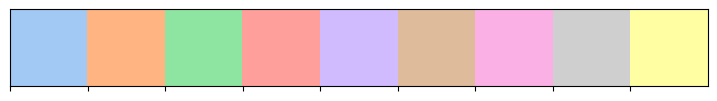

In [6]:
my_palette = sns.color_palette("pastel", 9)

sns.palplot(my_palette)

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_36906/2715281637.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby("ablation_type")["fact_score.direct_fact_score"].mean()
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_36906/2715281637.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df.groupby("ablation_type")["fact_score.direct_fact_score"].median()


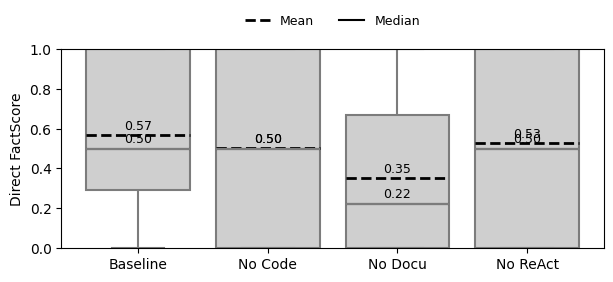

In [7]:
plt.figure(figsize=(7, 3.5))

# Draw boxplot
ax = sns.boxplot(
    data=df,
    x="ablation_type",
    y="fact_score.direct_fact_score",
    color=my_palette[7],
    showfliers=False,
    linewidth=1.5,
)

# X-tick metadata
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

# Compute stats
means = df.groupby("ablation_type")["fact_score.direct_fact_score"].mean()
medians = df.groupby("ablation_type")["fact_score.direct_fact_score"].median()
pos_map = {label: pos for label, pos in zip(xticklabels, xticks)}

# Overlay mean/median lines + annotations
for ablation, pos in pos_map.items():
    mean_val = means.get(ablation)
    median_val = medians.get(ablation)

    if mean_val is not None:
        plt.hlines(
            mean_val, pos - 0.4, pos + 0.4, colors="black", linestyles="--", linewidth=2
        )
        plt.text(
            pos,
            mean_val + 0.015,
            f"{mean_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

    if median_val is not None:
        plt.hlines(
            median_val,
            pos - 0.4,
            pos + 0.4,
            colors="black",
            linestyles="-",
            linewidth=1.5,
        )
        plt.text(
            pos,
            median_val + 0.015,
            f"{median_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

# Final styling
plt.xlabel("")
plt.ylabel("Direct FactScore")
plt.ylim(0, 1)

# Top-centered legend without frame
ax.legend(
    handles=[
        plt.Line2D([0], [0], color="black", linestyle="--", linewidth=2, label="Mean"),
        plt.Line2D(
            [0], [0], color="black", linestyle="-", linewidth=1.5, label="Median"
        ),
    ],
    loc="lower center",
    bbox_to_anchor=(0.5, 1.05),
    fontsize=9,
    frameon=False,
    ncol=2,
)

# Add margin for legend
plt.subplots_adjust(top=0.82, bottom=0.25)
plt.show()

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_36906/3569880240.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["ablation_type", "agent_judge_outcome"]).size().unstack(fill_value=0)


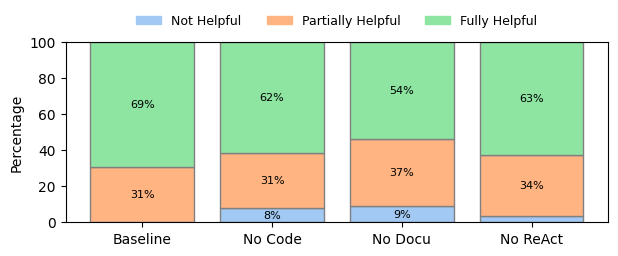

In [8]:
# Group and count by ablation_type instead of experiment_name
stacked_data = (
    df.groupby(["ablation_type", "agent_judge_outcome"]).size().unstack(fill_value=0)
)

# Desired outcome stacking order
desired_order = ["Not Helpful", "Partially Helpful", "Fully Helpful"]
stacked_data = stacked_data[desired_order]

# Convert to percentages row-wise
stacked_percent = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
bottom = [0] * len(stacked_percent)

for idx, outcome in enumerate(desired_order):
    values = stacked_percent[outcome].values
    bars = ax.bar(
        stacked_percent.index,
        values,
        bottom=bottom,
        label=outcome,
        color=my_palette[idx],
        edgecolor="gray",
    )

    # Annotate with percent labels (skip small segments)
    for i, (val, btm) in enumerate(zip(values, bottom)):
        if val >= 5:
            ax.text(
                i,
                btm + val / 2,
                f"{val:.0f}%",
                ha="center",
                va="center",
                fontsize=8,
                color="black",
            )

    bottom = [btm + val for btm, val in zip(bottom, values)]

# X-axis labels
ax.set_xticks(range(len(stacked_percent.index)))
ax.set_xticklabels(stacked_percent.index)

# Legend above
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color=my_palette[i], label=label)
    for i, label in enumerate(desired_order)
]
ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    fontsize=9,
    frameon=False,
    ncol=len(legend_handles),
)

# Adjust layout
fig.subplots_adjust(top=0.75, bottom=0.3)
plt.ylabel("Percentage")
plt.ylim(0, 100)
plt.show()

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_36906/576910714.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["smoothed_score"] = df.groupby("ablation_type")[


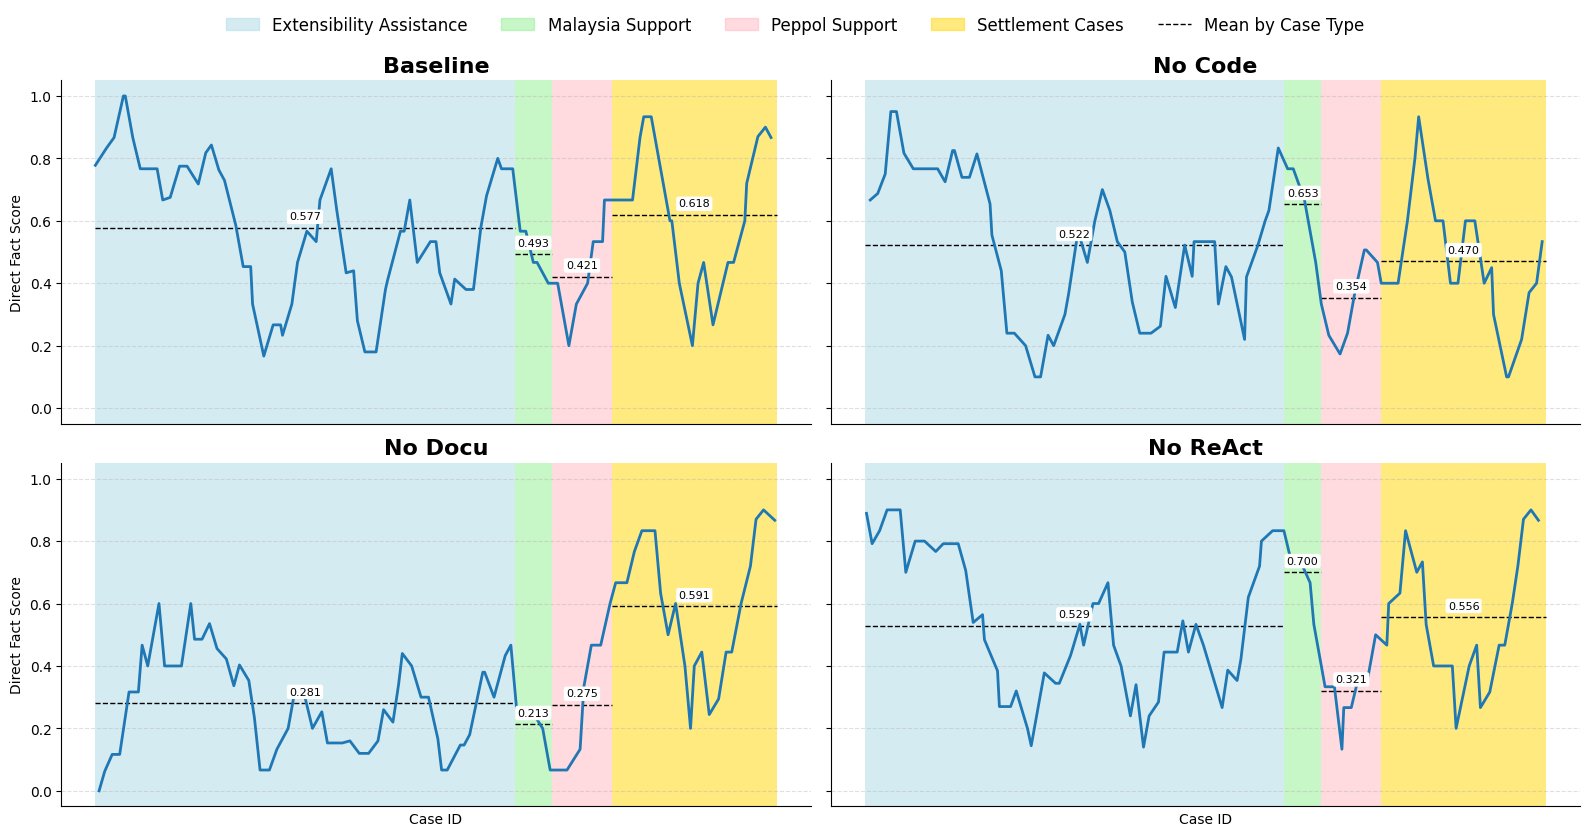

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# --- DATA PREPARATION ---
df = df.sort_values("id").reset_index(drop=True)
df["smoothed_score"] = df.groupby("ablation_type")[
    "fact_score.direct_fact_score"
].transform(lambda x: x.rolling(5, center=True, min_periods=1).mean())
df["x_pos"] = df.index

# Identify contiguous regions of the same case_type
df["case_type_change"] = df["case_type"] != df["case_type"].shift()
starts = df.index[df["case_type_change"]].tolist()
ends = starts[1:] + [len(df)]
regions = [
    (start, end, df.loc[start, "case_type"])
    for start, end in zip(starts, ends)
    if df.loc[start, "case_type"] != "Unknown"
]

# Define visible background colors (no "Unknown")
case_type_colors = {
    "Extensibility Assistance": "#ADD8E6",  # light blue
    "Malaysia Support": "#90EE90",  # light green
    "Peppol Support": "#FFB6C1",  # light pink
    "Settlement Cases": "#FFD700",  # gold
}


# --- PLOTTING FUNCTION ---
def plot_with_shading_and_means(data, color, **kwargs):
    ax = plt.gca()

    for start, end, case_label in regions:
        ax.axvspan(
            start, end, color=case_type_colors[case_label], alpha=0.5, linewidth=0
        )

        subdata = data[(data["x_pos"] >= start) & (data["x_pos"] < end)]
        if not subdata.empty:
            mean_val = subdata["smoothed_score"].mean()
            ax.hlines(mean_val, start, end, color="black", linestyle="--", linewidth=1)

            # Annotate mean with clean white background
            x_text = (start + end) / 2
            y_text = mean_val + 0.02
            ax.annotate(
                f"{mean_val:.3f}",
                xy=(x_text, y_text),
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
                bbox=dict(
                    facecolor="white", edgecolor="none", boxstyle="round,pad=0.2"
                ),
            )

    sns.lineplot(
        data=data, x="x_pos", y="smoothed_score", color=color, linewidth=2, **kwargs
    )


# --- FACET SETUP ---
g = sns.FacetGrid(
    df, col="ablation_type", col_wrap=2, height=4, aspect=2, sharex=True, sharey=True
)

g.map_dataframe(plot_with_shading_and_means)

# Axis styling
for ax in g.axes.flat:
    ax.set_xticks([])
    ax.grid(axis="y", linestyle="--", alpha=0.4)

g.set_axis_labels("Case ID", "Direct Fact Score")
g.set_titles("{col_name}", size=16, weight="bold")  # Improved subplot titles
g.fig.subplots_adjust(top=0.88, hspace=0.35)

# Legend above the figure
legend_patches = [
    Patch(color=color, label=label, alpha=0.5)
    for label, color in case_type_colors.items()
]
mean_line_legend = Line2D(
    [0], [0], color="black", lw=1, linestyle="--", label="Mean by Case Type"
)

g.fig.legend(
    handles=legend_patches + [mean_line_legend],
    loc="upper center",
    ncol=len(legend_patches) + 1,
    bbox_to_anchor=(0.5, 1.05),
    frameon=False,  # Remove legend box
    prop={"size": 12},  # Increase font size
)


plt.tight_layout()
plt.show()

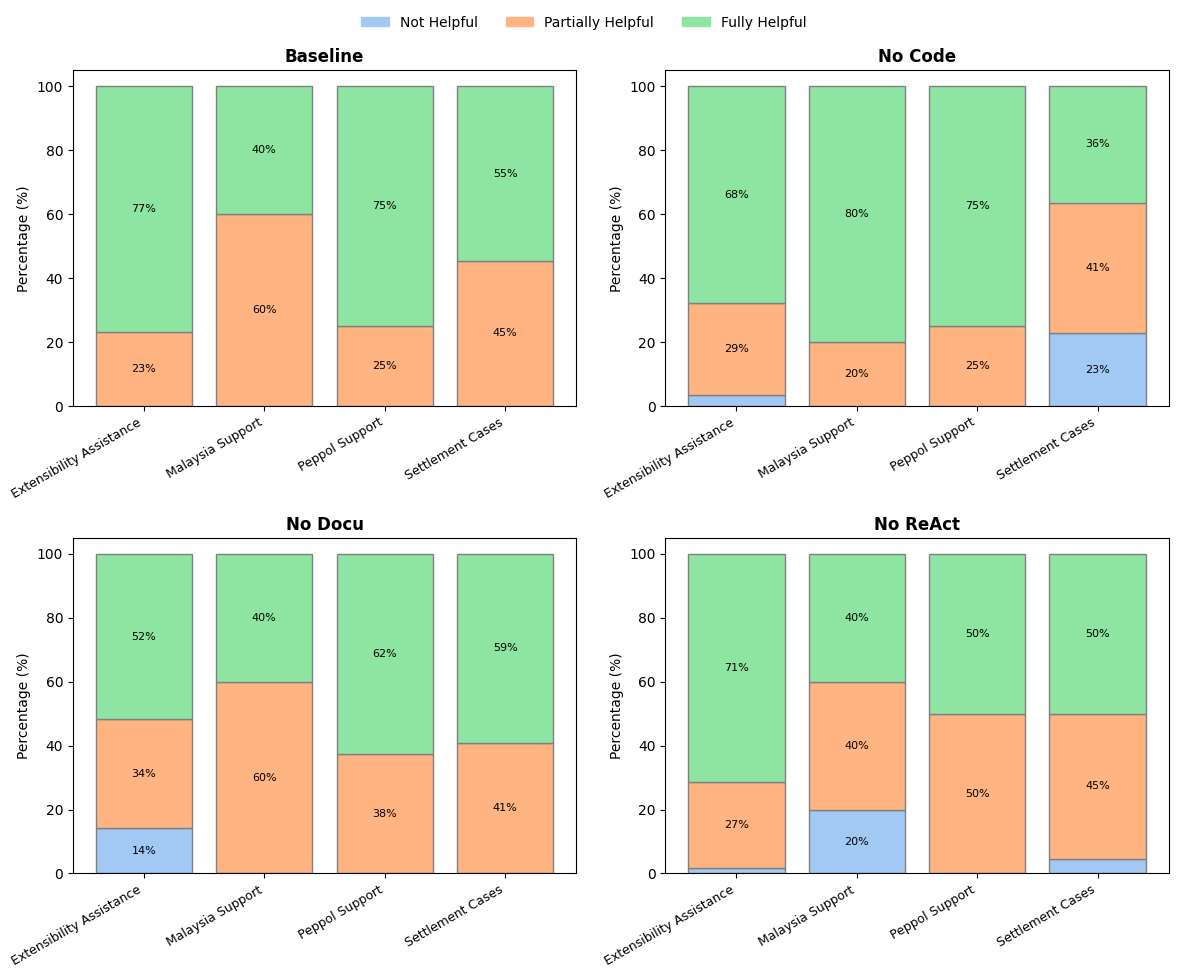

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup ---
desired_order = ["Not Helpful", "Partially Helpful", "Fully Helpful"]
ablation_types = (
    df["ablation_type"].cat.categories
    if df["ablation_type"].dtype.name == "category"
    else df["ablation_type"].unique()
)
num_plots = min(4, len(ablation_types))  # Support only up to 4 for 2x2 grid

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # For easy indexing

# Store for shared legend
legend_handles = []

# --- One Plot per Ablation ---
for idx, ablation in enumerate(ablation_types[:num_plots]):
    ax = axes[idx]
    subset = df[df["ablation_type"] == ablation]

    # Group by case_type and outcome
    grouped = (
        subset.groupby(["case_type", "agent_judge_outcome"])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=desired_order, fill_value=0)
    )

    # Normalize to percentages
    stacked_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

    bottom = [0] * len(stacked_percent)

    for outcome_idx, outcome in enumerate(desired_order):
        values = stacked_percent[outcome].values
        bars = ax.bar(
            stacked_percent.index,
            values,
            bottom=bottom,
            label=outcome,
            color=my_palette[outcome_idx],
            edgecolor="gray",
        )

        if idx == 0:
            # Only store legend once
            legend_handles.append(
                plt.Rectangle(
                    (0, 0), 1, 1, color=my_palette[outcome_idx], label=outcome
                )
            )

        # Annotate
        for i, (val, btm) in enumerate(zip(values, bottom)):
            if val >= 5:
                ax.text(
                    i,
                    btm + val / 2,
                    f"{val:.0f}%",
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="black",
                )

        bottom = [btm + val for btm, val in zip(bottom, values)]

    ax.set_title(ablation, fontsize=12, weight="bold")
    ax.set_ylabel("Percentage (%)")
    ax.set_xticks(range(len(stacked_percent.index)))
    ax.set_xticklabels(stacked_percent.index, rotation=30, ha="right", fontsize=9)

# Remove any unused axes (if <4 ablation types)
for j in range(idx + 1, 4):
    fig.delaxes(axes[j])

# Shared legend
fig.legend(
    handles=legend_handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.98),
    ncol=len(desired_order),
    fontsize=10,
    frameon=False,
)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for legend
plt.show()

In [12]:
import pandas as pd

# --- Grouped Means ---
mean_metrics = df.groupby("ablation_type").agg(
    {
        "fact_score.direct_fact_score": "mean",
        "excecution_time_seconds": "mean",
        "tokens_consumed.input_tokens": "mean",
        "tokens_consumed.output_tokens": "mean",
        "bert_score": "mean",
        "tool_calls_count": "mean",
    }
)

# --- Judge Outcome Percentages ---
outcome_counts = (
    df.groupby(["ablation_type", "agent_judge_outcome"]).size().unstack(fill_value=0)
)
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# --- Merge Tables ---
summary_table = pd.concat([mean_metrics, outcome_percentages], axis=1)

# --- Optional: Round values ---
summary_table = summary_table.round(2)

# --- Show Result ---
summary_table

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_36906/2339691763.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_metrics = df.groupby("ablation_type").agg(
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_36906/2339691763.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["ablation_type", "agent_judge_outcome"]).size().unstack(fill_value=0)


,fact_score.direct_fact_score,excecution_time_seconds,tokens_consumed.input_tokens,tokens_consumed.output_tokens,bert_score,tool_calls_count,Fully Helpful,Not Helpful,Partially Helpful
ablation_type,,,,,,,,,
Baseline,0.57,140.14,17201.74,2445.11,0.18,3.71,69.23,0.00,30.77
No Code,0.50,84.46,18866.26,2936.98,0.11,4.84,61.54,7.69,30.77
No Docu,0.35,60.63,18191.43,1052.30,0.14,4.41,53.85,8.79,37.36
No ReAct,0.53,119.25,23757.43,3306.77,0.17,5.46,62.64,3.30,34.07
